In [1]:
# Use the following command to install pyspark using pip
!pip install pyspark

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Use the following command to install seaborn using pip
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Use the following command to install scikit-learn using pip
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [4]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import the numpy library and give it the alias 'np'
import numpy as np 

# Import the pandas library and alias it as 'pd'
import pandas as pd


# Importing Spark-related libraries
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, split
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel, TrainValidationSplit
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

# Importing a utility function from scikit-learn
from sklearn.metrics import confusion_matrix

# Setting Seaborn theme for better visualizations
sns.set_theme(style="darkgrid")

## Create the spark session

In [6]:
# Create a SparkSession instance with the specified configuration
# The 'master' parameter sets the number of local cores to use (2 in this case)
# The 'appName' parameter sets a name for the Spark application
spark = SparkSession.builder.master("local[2]").appName("Top Hits Spotify from 2000-2019").getOrCreate()

In [7]:
spark

In [8]:
# Create a SparkContext
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Top Hits Spotify from 2000-2019>

In [9]:
# Create an instance of SQLContext using the Spark session's SparkContext
sqlContext = SQLContext(spark.sparkContext)
sqlContext

/home/amar/.local/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Load Data

In [10]:
#Define the structure of the table
schema = StructType([
    StructField("artist", StringType(), nullable=True),
    StructField("song", StringType(), nullable=True),
    StructField("duration_ms", IntegerType(), nullable=True),
    StructField("explicit", BooleanType(), nullable=True),
    StructField("year", IntegerType(), nullable=True),
    StructField("popularity", IntegerType(), nullable=True),
    StructField("danceability", FloatType(), nullable=True),
    StructField("energy", FloatType(), nullable=True),
    StructField("key", IntegerType(), nullable=True),
    StructField("loudness", FloatType(), nullable=True),
    StructField("mode", IntegerType(), nullable=True),
    StructField("speechiness", FloatType(), nullable=True),
    StructField("acousticness", FloatType(), nullable=True),
    StructField("instrumentalness", FloatType(), nullable=True),
    StructField("liveness", FloatType(), nullable=True),
    StructField("valence", FloatType(), nullable=True),
    StructField("tempo", FloatType(), nullable=True),
    StructField("genre", StringType(), nullable=True)]
)
#Dataset is(Top Hits Spotify from 2000-2019)
hits_df = spark.read.csv('songs_normalize.csv',schema=schema,header=True)
hits_df = hits_df.withColumnRenamed("duration_ms", "duration")

In [12]:
hits_df.count() #rows

2000

In [13]:
hits_df.columns

['artist',
 'song',
 'duration',
 'explicit',
 'year',
 'popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'genre']

In [14]:
hits_df.show(5)

+--------------+--------------------+--------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+------------+
|        artist|                song|duration|explicit|year|popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|       genre|
+--------------+--------------------+--------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+------------+
|Britney Spears|Oops!...I Did It ...|  211160|   false|2000|        77|       0.751| 0.834|  1|  -5.444|   0|     0.0437|         0.3|         1.77E-5|   0.355|  0.894| 95.053|         pop|
|     blink-182|All The Small Things|  167066|   false|1999|        79|       0.434| 0.897|  0|  -4.918|   1|     0.0488|      0.0103|             0.0|   0.612|  0.684|148.726|   rock, pop|
|    Faith Hill|             Breathe|  250546|   f

In [15]:
hits_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- song: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- year: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- genre: string (nullable = true)



## Preprocessing Data

In [16]:
# Add the counts from before 2000 and after 2019 to get the total count
hits_df.where('year<2000').count() + hits_df.where('year>2019').count()


42

In [17]:
# Filtering the 'hits_df' DataFrame to include only rows with years between 2000 and 2019.
hits_df = hits_df.filter('year>=2000').filter('year<=2019')
# Counting the number of rows in the filtered DataFrame.
hits_df.count()


1958

In [18]:
#Convert duration from milliseconds to seconds
hits_df = hits_df.withColumn("duration", col("duration")/1000) 

In [19]:
hits_df.show(5)

+---------------+--------------------+--------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|         artist|                song|duration|explicit|year|popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|      genre|
+---------------+--------------------+--------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
| Britney Spears|Oops!...I Did It ...|  211.16|   false|2000|        77|       0.751| 0.834|  1|  -5.444|   0|     0.0437|         0.3|         1.77E-5|   0.355|  0.894| 95.053|        pop|
|       Bon Jovi|        It's My Life| 224.493|   false|2000|        78|       0.551| 0.913|  0|  -4.063|   0|     0.0466|      0.0263|         1.35E-5|   0.347|  0.544|119.992|rock, metal|
|         *NSYNC|         Bye Bye Bye|  200.56|   

## Exploratory Data Analysis

In [20]:
#Top 5 longest and shortest songs
# Sorting the DataFrame 'hits_df' in descending order based on the 'duration' column
# orderBy(col("duration").desc()) sorts the DataFrame by the 'duration' column in descending order
sorted_hits_df = hits_df.orderBy(col("duration").desc())

# Selecting specific columns 'artist', 'song', and 'duration' from the sorted DataFrame
# select('artist', 'song', 'duration') retains only the specified columns in the DataFrame
selected_columns_df = sorted_hits_df.select('artist', 'song', 'duration')

# Displaying the top 5 rows of the DataFrame with selected columns
# show(5) displays the first 5 rows of the DataFrame
selected_columns_df.show(5)



+-----------------+--------------------+--------+
|           artist|                song|duration|
+-----------------+--------------------+--------+
|Justin Timberlake|             Mirrors| 484.146|
|    Roger Sanchez|      Another Chance| 452.906|
|Justin Timberlake|What Goes Around....| 448.573|
|Justin Timberlake|LoveStoned / I Th...| 444.333|
|      Dirty Vegas|          Days Go By| 432.146|
+-----------------+--------------------+--------+
only showing top 5 rows



In [21]:
# Sorting the 'hits_df' DataFrame in ascending order based on the 'duration' column.
sorted_hits_df = hits_df.orderBy(col("duration").asc())

# Selecting specific columns 'artist', 'song', and 'duration' from the sorted DataFrame.
selected_columns_df = sorted_hits_df.select('artist', 'song', 'duration')

# Displaying the top 5 rows of the DataFrame with the selected columns.
selected_columns_df.show(5)

+------------+--------------+--------+
|      artist|          song|duration|
+------------+--------------+--------+
|   Lil Nas X| Old Town Road|   113.0|
|   Lil Nas X|        Panini| 114.893|
|XXXTENTACION|Jocelyn Flores| 119.133|
|XXXTENTACION|       changes| 121.886|
|    Lil Pump|    Gucci Gang| 124.055|
+------------+--------------+--------+
only showing top 5 rows



-Some artist appear more than once, which also reflects the characteristics of their works to a certain extent.

In [22]:
#Top hits by year
# Group the 'hits_df' DataFrame by the 'year' column and count the occurrences in each group
grouped_hits_df = hits_df.groupBy(col('year')).count()

# Order the resulting DataFrame by the 'year' column in ascending order
ordered_hits_df = grouped_hits_df.orderBy('year')



In [23]:
ordered_hits_df.show()

+----+-----+
|year|count|
+----+-----+
|2000|   74|
|2001|  108|
|2002|   90|
|2003|   97|
|2004|   96|
|2005|  104|
|2006|   95|
|2007|   94|
|2008|   97|
|2009|   84|
|2010|  107|
|2011|   99|
|2012|  115|
|2013|   89|
|2014|  104|
|2015|   99|
|2016|   99|
|2017|  111|
|2018|  107|
|2019|   89|
+----+-----+



## Artists

In [24]:
# Grouping the hits_df DataFrame by 'artist' and counting the number of songs by each artist
songsbyartist_df = hits_df.groupBy(col('artist')).count()

# Grouping the hits_df DataFrame by 'artist' and calculating the average popularity for each artist
popbyartist_df = hits_df.groupBy(col('artist')).mean().select('artist', 'avg(popularity)')

# Joining the 'songsbyartist_df' and 'popbyartist_df' DataFrames on the 'artist' column using an inner join
# This combines the song count and average popularity information for each artist
songspopbyartist_df = songsbyartist_df.join(popbyartist_df, 'artist', 'inner')



## Genres

In [25]:
# Split the 'genre' column by ', ' and explode the resulting array
genreexp = hits_df.withColumn("genre", split(hits_df.genre, ', ', -1)) \
                  .toPandas() \
                  .explode('genre') \
                  .reset_index(drop=True)  
genreexp


,artist,song,duration,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211.160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053001,pop
1,Bon Jovi,It's My Life,224.493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000014,0.3470,0.544,119.991997,rock
2,Bon Jovi,It's My Life,224.493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000014,0.3470,0.544,119.991997,metal
3,*NSYNC,Bye Bye Bye,200.560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656006,pop
4,Eminem,The Real Slim Shady,284.200,True,2000,86,0.949,0.661,5,-4.244,0,0.0572,0.0302,0.000000,0.0454,0.760,104.503998,hip hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,Taylor Swift,Cruel Summer,178.426,False,2019,78,0.552,0.702,9,-5.707,1,0.1570,0.1170,0.000021,0.1050,0.564,169.994003,pop
3626,Blanco Brown,The Git Up,200.593,False,2019,69,0.847,0.678,9,-8.635,1,0.1090,0.0669,0.000000,0.2740,0.811,97.984001,hip hop
3627,Blanco Brown,The Git Up,200.593,False,2019,69,0.847,0.678,9,-8.635,1,0.1090,0.0669,0.000000,0.2740,0.811,97.984001,country
3628,Sam Smith,Dancing With A Stranger (with Normani),171.029,False,2019,75,0.741,0.520,8,-7.513,1,0.0656,0.4500,0.000002,0.2220,0.347,102.998001,pop


In [26]:
genreexp.genre.unique()

array(['pop', 'rock', 'metal', 'hip hop', 'Dance/Electronic', 'R&B',
       'country', 'latin', 'Folk/Acoustic', 'easy listening',
       'World/Traditional', 'set()', 'blues', 'jazz', 'classical'],
      dtype=object)

In [27]:
# Found that set() is an abnormal value, to be deleted

# Remove rows where the genre is 'set()'
genreexp = genreexp[genreexp['genre'] != 'set()']

# Select only numeric columns (integers and floats)
numeric_columns = genreexp.select_dtypes(include=['int', 'float'])

# Group the numeric columns by genre and calculate the average (mean) value for each genre
avgbygenre = numeric_columns.groupby(genreexp['genre']).mean()

# Drop the 'year' column from the result, as it's not needed
avgbygenre.drop(['year'], axis=1, inplace=True)
avgbygenre

,duration,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
genre,,,,,,,,,,,,,
Dance/Electronic,215.846134,54.966408,0.666744,0.766687,5.754522,-5.151388,0.506460,0.079919,0.110175,0.037666,0.182850,0.537117,124.054489
Folk/Acoustic,220.620000,59.947368,0.555105,0.720789,4.421053,-6.480842,0.789474,0.042058,0.199999,0.045545,0.193379,0.560684,109.683258
R&B,239.067526,58.629797,0.689108,0.663233,5.331828,-5.879093,0.523702,0.114886,0.150546,0.006579,0.162687,0.562708,115.507378
World/Traditional,216.728556,53.444444,0.577111,0.692889,4.222222,-6.354889,0.666667,0.078433,0.260068,0.220410,0.204456,0.641667,111.259888
blues,238.866667,38.666667,0.607333,0.692667,5.000000,-5.511667,0.333333,0.080533,0.014537,0.149010,0.216667,0.434000,131.272659
classical,219.560000,63.000000,0.590000,0.578000,10.000000,-5.798000,0.000000,0.052800,0.612000,0.000162,0.083700,0.264000,81.663002
country,220.810050,56.100000,0.580600,0.729700,5.800000,-5.397300,0.800000,0.060690,0.221801,0.000014,0.181940,0.533750,130.235809
easy listening,238.770667,60.833333,0.580500,0.658667,6.666667,-8.208500,0.500000,0.052600,0.256737,0.044731,0.140733,0.510000,121.166832
hip hop,234.056229,61.975260,0.717087,0.698659,5.602865,-5.595821,0.544271,0.151741,0.116307,0.006760,0.187508,0.560885,118.033691


In [28]:
# Reset the index of the 'avgbygenre' DataFrame in-place.
# This is done to remove the current index and replace it with the default integer index.
avgbygenre.reset_index(inplace=True)


## Features correlation

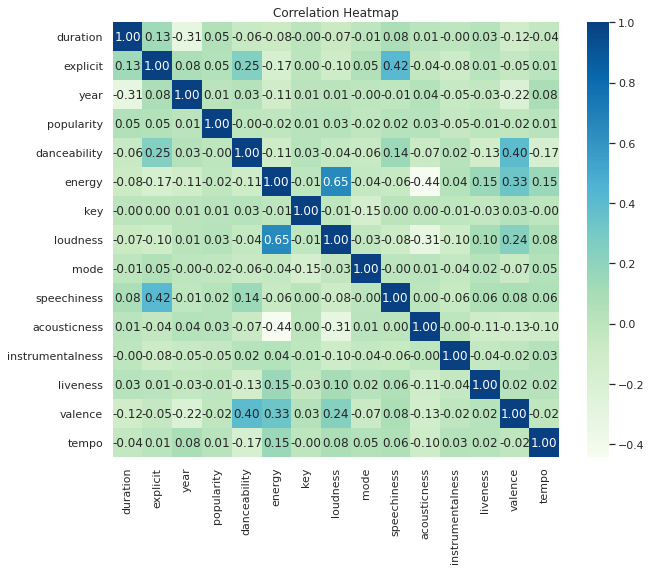

In [29]:
# Correlation between features

# List to store the names of numeric columns
numeric_columns = [col_name for col_name, col_type in hits_df.dtypes if col_type != 'string']

# Create a correlation matrix using Pearson correlation method
corr_matrix = hits_df.select(*numeric_columns).toPandas().corr(method='pearson')

# Set up the plot figure
plt.figure(figsize=(10, 8))

# Create a heatmap using the correlation matrix, with color map 'GnBu'
sns.heatmap(corr_matrix, cmap='GnBu', annot=True, fmt=".2f")

# Set the title of the plot
plt.title("Correlation Heatmap")

# Display the plot
plt.show()

-Loudness and energy have the highest positive correlation, and acousticity and energy have a strong negative correlation.
We will further explore the characteristics of each feature of songs in each category.

In [30]:
genre_num_songs = genreexp.groupby("genre").size().reset_index()
genre_num_songs.columns = ["genre", "songs"]
genre_num_songs.drop(genre_num_songs[genre_num_songs.songs<5].index, inplace=True)  
valid_genres = genre_num_songs.genre.values
#Iterate for each genre
# Iterate for each genre
for genre in valid_genres:
    data = avgbygenre.drop(["popularity"], axis=1)[avgbygenre.genre == genre]
    # Exclude features with different scales
    data = data.drop(["genre", "tempo", "duration", "key", "loudness"], axis=1).transpose().reset_index()
    data.columns = ["feature", "value"]
    
 



## Attempt to Predict Popularity

In [31]:
#First, we try to predict popularity and look for features that are strongly correlated with popularity.

hits_df.show(5)

+---------------+--------------------+--------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
|         artist|                song|duration|explicit|year|popularity|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|      genre|
+---------------+--------------------+--------+--------+----+----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+
| Britney Spears|Oops!...I Did It ...|  211.16|   false|2000|        77|       0.751| 0.834|  1|  -5.444|   0|     0.0437|         0.3|         1.77E-5|   0.355|  0.894| 95.053|        pop|
|       Bon Jovi|        It's My Life| 224.493|   false|2000|        78|       0.551| 0.913|  0|  -4.063|   0|     0.0466|      0.0263|         1.35E-5|   0.347|  0.544|119.992|rock, metal|
|         *NSYNC|         Bye Bye Bye|  200.56|   

In [32]:
# List of columns representing the features we want to include in the model
featureCols = ["duration", "explicit", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]

# Create a VectorAssembler to combine the specified feature columns into a single feature vector column
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

# Apply the VectorAssembler to the 'hits_df' DataFrame to transform the selected feature columns into a feature vector
assembled_df = assembler.transform(hits_df)

In [33]:
# Split the data into train and test sets
train_data, test_data = assembled_df.randomSplit([.8,.2], seed=2022)  #Split the data into train and test sets

lr = (LinearRegression(featuresCol='features', labelCol="popularity", predictionCol='pred-popularity', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))
linearModel = lr.fit(train_data)
linearModel.coefficients


DenseVector([0.0256, 1.0368, 0.0, 0.0, 0.0961, 0.489, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0191])

In [34]:
# Generate predictions

# Apply the trained linear model to make predictions on the test data
predictions = linearModel.transform(test_data)

# Create a DataFrame containing both the predicted popularity and the actual popularity from the test data
predandlabel = predictions.select("pred-popularity", "popularity")

# Display the DataFrame showing the predicted and actual popularity values
predandlabel.show()


23/08/28 09:03:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+----------+
|   pred-popularity|popularity|
+------------------+----------+
| 59.21298749647293|        50|
| 58.34037388385513|        71|
| 61.03719228529486|        78|
|60.685372604420834|        57|
| 58.63696518424325|        56|
|60.565868023276316|        70|
|61.634539509121176|        67|
| 59.79794952100309|        72|
|  60.4051179182083|        81|
|57.134014531715955|        42|
|58.561004689661125|        53|
|  57.3393807903338|        69|
| 61.59220639509376|        57|
| 57.88467897523961|         1|
| 60.61312456183695|         2|
| 59.02179084741277|         0|
|58.890647335609565|        74|
|59.222675665674394|        68|
| 61.78817216712596|        65|
| 60.72204191016223|        16|
+------------------+----------+
only showing top 20 rows



In [35]:
linearModel.summary.r2

0.007135417239890418

In [36]:
linearModel.summary.rootMeanSquaredError


21.331626280839156

-Although the model is relatively rough, but seeing that the prediction effect of the model is very, very poor, it can basically be considered that the idea of ​​predicting popularity is not feasible.



## Attempt to predict Genre

-In the exploratory data analysis, it is found that the songs of each category show different characteristics in terms of characteristics, so below we try to predict the genre to which they belong based on these feature values ​​of each song.

-Here we use another data set with a larger sample size, Dataset of songs in Spotify, which contains 42,305 songs. The features contained are basically the same as those of Top Hits Spotify from 2000-2019, and the classification of genre is clearer.



In [37]:
# Define the schema for the DataFrame
schema = StructType([
    StructField("danceability", FloatType(), nullable=True),
    StructField("energy", FloatType(), nullable=True),
    StructField("key", IntegerType(), nullable=True),
    StructField("loudness", FloatType(), nullable=True),
    StructField("mode", IntegerType(), nullable=True),
    StructField("speechiness", FloatType(), nullable=True),
    StructField("acousticness", FloatType(), nullable=True),
    StructField("instrumentalness", FloatType(), nullable=True),
    StructField("liveness", FloatType(), nullable=True),
    StructField("valence", FloatType(), nullable=True),
    StructField("tempo", FloatType(), nullable=True),
    StructField("type", StringType(), nullable=True),
    StructField("id", StringType(), nullable=True),
    StructField("uri", StringType(), nullable=True),
    StructField("track_href", StringType(), nullable=True),
    StructField("analysis_url", StringType(), nullable=True),
    StructField("duration_ms", IntegerType(), nullable=True),
    StructField("time_signature", IntegerType(), nullable=True),
    StructField("genre", StringType(), nullable=True),
    StructField("song_name", StringType(), nullable=True),
    StructField("Unnamed: 0", FloatType(), nullable=True),
    StructField("title", StringType(), nullable=True)
])

# Read the CSV file with the defined schema and header
songs_df = spark.read.csv(path='genres_v2.csv', schema=schema, header=True)

# Drop unnecessary columns
columns_to_drop = ["title", "Unnamed: 0", "song_name", "analysis_url", "track_href", "uri", "id", "type"]
songs_df = songs_df.drop(*columns_to_drop)

In [38]:
songs_df.show(5)

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+---------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|    genre|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+---------+
|       0.831| 0.814|  2|  -7.364|   1|       0.42|      0.0598|          0.0134|  0.0556|  0.389|156.985|     124539|             4|Dark Trap|
|       0.719| 0.493|  8|   -7.23|   1|     0.0794|       0.401|             0.0|   0.118|  0.124| 115.08|     224427|             4|Dark Trap|
|        0.85| 0.893|  5|  -4.783|   1|     0.0623|      0.0138|         4.14E-6|   0.372| 0.0391| 218.05|      98821|             4|Dark Trap|
|       0.476| 0.781|  0|   -4.71|   1|      0.103|      0.0237|             0.0|   0.114|  0.175|186.948|     123661|             3|Dar

In [39]:
# Group the DataFrame 'songs_df' by the 'genre' column and count the occurrences in each group
grouped_by_genre = songs_df.groupBy('genre').count()

# Display the result of the grouping and counting operation
grouped_by_genre.show()


+---------------+-----+
|          genre|count|
+---------------+-----+
|Underground Rap| 5875|
|            RnB| 2099|
|     Trap Metal| 1956|
|         techno| 2956|
|      Dark Trap| 4578|
|      techhouse| 2975|
|            Emo| 1680|
|            Pop|  461|
|            Rap| 1848|
|         Hiphop| 3028|
|         trance| 2999|
|      hardstyle| 2936|
|           trap| 2987|
|      psytrance| 2961|
|            dnb| 2966|
+---------------+-----+



In [40]:
# Convert the Spark DataFrame to a Pandas DataFrame and check for missing values (NaN/null)
pandas_df = songs_df.toPandas()

# Calculate the sum of missing values for each column in the Pandas DataFrame
missing_value_counts = pandas_df.isna().sum()

# Print or use the missing value counts for further analysis or debugging
print(missing_value_counts)

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
genre               0
dtype: int64


In [41]:
#Encode the category variable genre

# Create a StringIndexer model to convert the 'genre' column from strings to numerical indices.
indexer = StringIndexer(inputCol="genre", outputCol="genreIndex")

# Fit the StringIndexer model to the 'songs_df' DataFrame and transform the data.
indexedsongs_df = indexer.fit(songs_df).transform(songs_df)


In [42]:
# List of feature column names
featureCols = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness",
               "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

# Create a VectorAssembler to combine features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

# Transform the data to include the assembled feature vector
assembled_df = assembler.transform(indexedsongs_df)

# Split the data into train and test sets
train_data, test_data = assembled_df.randomSplit([.8, .2], seed=2022)

# Function to fit a model, make predictions, and calculate accuracy
def fit_and_accuracy(model, train_data, test_data):
    fittedmodel = model.fit(train_data)
    predictions = fittedmodel.transform(test_data)
    predandlabel = predictions.select('genreIndex', 'predgenreIndex')
    evaluator = MulticlassClassificationEvaluator(predictionCol='predgenreIndex', labelCol='genreIndex')
    accuracy = evaluator.evaluate(predandlabel, {evaluator.metricName: "accuracy"})
    return accuracy

# List of machine learning models to evaluate
models = [DecisionTreeClassifier(featuresCol='features', labelCol="genreIndex", predictionCol='predgenreIndex', seed=2022),
          RandomForestClassifier(featuresCol='features', labelCol="genreIndex", predictionCol='predgenreIndex', seed=2022),
          MultilayerPerceptronClassifier(featuresCol='features', labelCol="genreIndex", predictionCol='predgenreIndex', layers=[13, 5, 10, 5, 10, 15], seed=2022)
         ]

# Loop through models, fit them, evaluate accuracy, and print results
for model in models:
    accuracy = fit_and_accuracy(model, train_data, test_data)
    print(model, accuracy)


DecisionTreeClassifier_85d8aa0ed410 0.522210563133963


RandomForestClassifier_379624173efa 0.5708289611752361


MultilayerPerceptronClassifier_f989956e4687 0.13571178733823014


In [43]:
#Multiple threads perform parameter search on random forest

# Define a dictionary containing different values for hyperparameters for grid search
paragrid = {'maxDepth': [5, 10, 15], 'numTrees': [10, 20, 30], 'minInfoGain': [0.001, 0.01]}

# Extract individual hyperparameter value lists from the dictionary
infogainlst = paragrid['minInfoGain']
numtreelst = paragrid['numTrees']

# Define a function for Random Forest Classifier grid search
def rfcgridsearch(i):
    # Loop through each minInfoGain value
    for j in infogainlst:
        # Loop through each numTrees value
        for k in numtreelst:
            # Create a RandomForestClassifier model with specified hyperparameters
            model = RandomForestClassifier(featuresCol='features', labelCol="genreIndex", predictionCol='predgenreIndex', seed=2022, maxDepth=i, minInfoGain=j, numTrees=k)
            
            # Fit the model and calculate accuracy
            accuracy = fit_and_accuracy(model, train_data, test_data)
            
            # Print the combination of hyperparameters and the corresponding accuracy
            print('maxDepth =', i, 'minInfoGain =', j, 'numTrees =', k, 'accuracy =', accuracy)

# Import threading module and create threads for parallel execution
import threading
# Loop through maxDepth values from 5 to 20 in steps of 5
for i in range(5, 20, 5):
    # Create a thread for the rfcgridsearch function with the current maxDepth value as argument
    t = threading.Thread(target=rfcgridsearch, args=(i,))
    # Start the thread
    t.start()

maxDepth = 5 minInfoGain = 0.001 numTrees = 10 accuracy = 0.5707123702926431


23/08/28 09:09:09 WARN DAGScheduler: Broadcasting large task binary with size 1514.8 KiB
23/08/28 09:09:17 WARN DAGScheduler: Broadcasting large task binary with size 1514.8 KiB
23/08/28 09:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/28 09:09:31 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/28 09:09:35 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/08/28 09:09:51 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/08/28 09:09:57 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


maxDepth = 10 minInfoGain = 0.001 numTrees = 10 accuracy = 0.6450973533869652


23/08/28 09:10:03 WARN DAGScheduler: Broadcasting large task binary with size 1199.5 KiB
23/08/28 09:10:15 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
23/08/28 09:10:21 WARN DAGScheduler: Broadcasting large task binary with size 1445.5 KiB
23/08/28 09:10:39 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
23/08/28 09:10:48 WARN DAGScheduler: Broadcasting large task binary with size 1592.2 KiB


maxDepth = 5 minInfoGain = 0.001 numTrees = 20 accuracy = 0.5708289611752361


23/08/28 09:11:06 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
23/08/28 09:11:13 WARN DAGScheduler: Broadcasting large task binary with size 1628.2 KiB
23/08/28 09:11:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


maxDepth = 15 minInfoGain = 0.001 numTrees = 10 accuracy = 0.639734172787688


23/08/28 09:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1571.7 KiB
23/08/28 09:11:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/08/28 09:12:10 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


maxDepth = 5 minInfoGain = 0.001 numTrees = 30 accuracy = 0.5757257782441413


23/08/28 09:12:18 WARN DAGScheduler: Broadcasting large task binary with size 1235.1 KiB


In [44]:
#The optimal parameters are maxDepth=10, minInfoGain=0.001, numTrees=30

# Create a RandomForestClassifier with specified parameters
bestmodel = RandomForestClassifier(featuresCol='features', labelCol="genreIndex", predictionCol='predgenreIndex', seed=2022, maxDepth=10, minInfoGain=0.001, numTrees=30)

# Define a function to fit the model and calculate accuracy
def fit_and_accuracy(model, train_data, test_data):
    fitted_model = model.fit(train_data)
    predictions = fitted_model.transform(test_data)
    correct_predictions = predictions.filter(predictions.genreIndex == predictions.predgenreIndex).count()
    total_predictions = predictions.count()
    accuracy = correct_predictions / total_predictions
    return accuracy

# Calculate accuracy using the fit_and_accuracy function
accuracy = fit_and_accuracy(bestmodel, train_data, test_data)

# Fit the best model on the training data
fittedmodel = bestmodel.fit(train_data)

# Make predictions on the test data
predictions = fittedmodel.transform(test_data)

# Select relevant columns from predictions for comparison
predandlabel = predictions.select('genreIndex', 'predgenreIndex')

23/08/28 09:12:36 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


maxDepth = 10 minInfoGain = 0.001 numTrees = 20 accuracy = 0.6492946251603124


23/08/28 09:12:58 WARN DAGScheduler: Broadcasting large task binary with size 1571.7 KiB
23/08/28 09:13:09 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/08/28 09:13:26 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


maxDepth = 5 minInfoGain = 0.01 numTrees = 10 accuracy = 0.5629007811589134


23/08/28 09:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1235.1 KiB
23/08/28 09:13:47 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
23/08/28 09:13:56 WARN DAGScheduler: Broadcasting large task binary with size 1786.0 KiB
23/08/28 09:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB
23/08/28 09:14:10 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
23/08/28 09:14:18 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/28 09:14:30 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB
23/08/28 09:14:31 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/28 09:14:52 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/08/28 09:14:57 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
23/08/28 09:15:02 WARN DAGScheduler: Broadcasting large task binary with size 1184.1 KiB
23/08/28 09:15:04 WARN DAGScheduler: 

maxDepth = 5 minInfoGain = 0.01 numTrees = 20 accuracy = 0.5595196455637169


maxDepth = 10 minInfoGain = 0.001 numTrees = 30 accuracy = 0.6550075784073686


23/08/28 09:18:46 WARN DAGScheduler: Broadcasting large task binary with size 26.0 MiB


maxDepth = 15 minInfoGain = 0.001 numTrees = 20 accuracy = 0.645913489565116


23/08/28 09:20:23 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB
23/08/28 09:20:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


maxDepth = 5 minInfoGain = 0.01 numTrees = 30 accuracy = 0.5851696397341728


23/08/28 09:21:02 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB
23/08/28 09:21:13 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/08/28 09:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1277.1 KiB
23/08/28 09:21:33 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/08/28 09:21:41 WARN DAGScheduler: Broadcasting large task binary with size 1184.1 KiB
23/08/28 09:21:56 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/28 09:21:58 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
23/08/28 09:22:25 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/08/28 09:22:38 WARN DAGScheduler: Broadcasting large task binary with size 2010.7 KiB
23/08/28 09:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1899.7 KiB
23/08/28 09:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1184.1 KiB
23/08/28 09:23:34 WARN DAGScheduler:

maxDepth = 10 minInfoGain = 0.01 numTrees = 10 accuracy = 0.6378687186662003


23/08/28 09:23:55 WARN DAGScheduler: Broadcasting large task binary with size 1899.7 KiB
23/08/28 09:24:36 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
23/08/28 09:25:10 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/08/28 09:25:47 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
23/08/28 09:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1360.9 KiB
23/08/28 09:26:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/08/28 09:26:18 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/08/28 09:26:42 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/08/28 09:26:49 WARN DAGScheduler: Broadcasting large task binary with size 29.5 MiB
23/08/28 09:27:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/08/28 09:27:25 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


maxDepth = 10 minInfoGain = 0.01 numTrees = 20 accuracy = 0.6411332633788038


23/08/28 09:27:58 WARN DAGScheduler: Broadcasting large task binary with size 36.5 MiB


23/08/28 09:28:20 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/08/28 09:28:28 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


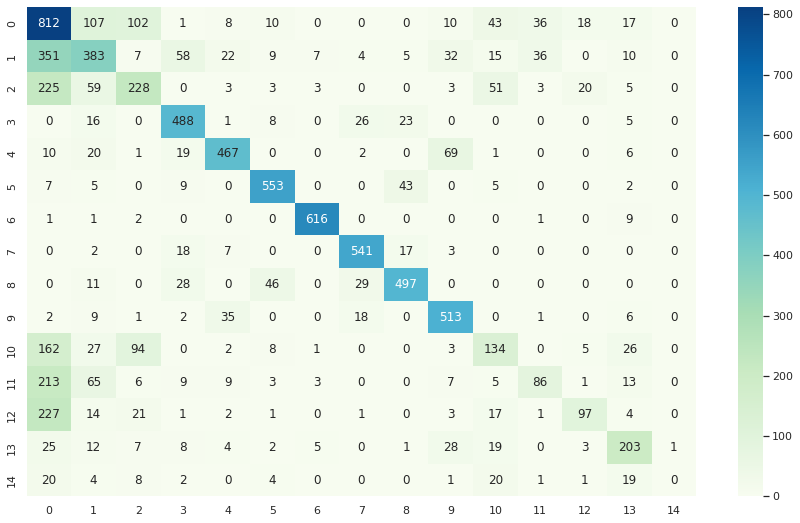

23/08/28 09:29:01 WARN DAGScheduler: Broadcasting large task binary with size 47.2 MiB
23/08/28 09:29:22 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/08/28 09:29:38 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
23/08/28 09:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1111.5 KiB
23/08/28 09:29:49 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
23/08/28 09:29:54 WARN DAGScheduler: Broadcasting large task binary with size 2016.5 KiB
23/08/28 09:29:58 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
23/08/28 09:30:04 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/08/28 09:30:18 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/08/28 09:30:22 WARN DAGScheduler: Broadcasting large task binary with size 39.1 MiB
23/08/28 09:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1427.5 KiB


maxDepth = 15 minInfoGain = 0.001 numTrees = 30 accuracy = 0.6540748513466247


23/08/28 09:30:41 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


maxDepth = 10 minInfoGain = 0.01 numTrees = 30 accuracy = 0.6435816719132564


23/08/28 09:30:57 WARN DAGScheduler: Broadcasting large task binary with size 1277.1 KiB
23/08/28 09:31:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/08/28 09:31:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
23/08/28 09:31:11 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
23/08/28 09:31:17 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
23/08/28 09:31:24 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/08/28 09:31:31 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
23/08/28 09:31:40 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


maxDepth = 15 minInfoGain = 0.01 numTrees = 10 accuracy = 0.6420659904395476


23/08/28 09:31:57 WARN DAGScheduler: Broadcasting large task binary with size 1360.9 KiB
23/08/28 09:32:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/08/28 09:32:05 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/08/28 09:32:11 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
23/08/28 09:32:15 WARN DAGScheduler: Broadcasting large task binary with size 1285.4 KiB
23/08/28 09:32:21 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
23/08/28 09:32:26 WARN DAGScheduler: Broadcasting large task binary with size 1640.7 KiB
23/08/28 09:32:30 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
23/08/28 09:32:34 WARN DAGScheduler: Broadcasting large task binary with size 1880.7 KiB
23/08/28 09:32:45 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
23/08/28 09:32:51 WARN DAGScheduler: Broadcasting large task binary with size 1909.2 KiB
23/08/28 09:33:01 WARN DAGScheduler:

maxDepth = 15 minInfoGain = 0.01 numTrees = 20 accuracy = 0.6475457619214178


23/08/28 09:33:42 WARN DAGScheduler: Broadcasting large task binary with size 1111.5 KiB
23/08/28 09:33:46 WARN DAGScheduler: Broadcasting large task binary with size 2016.5 KiB
23/08/28 09:33:51 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
23/08/28 09:33:59 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/08/28 09:34:04 WARN DAGScheduler: Broadcasting large task binary with size 1427.5 KiB
23/08/28 09:34:11 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
23/08/28 09:34:18 WARN DAGScheduler: Broadcasting large task binary with size 1967.7 KiB
23/08/28 09:34:26 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
23/08/28 09:34:36 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/08/28 09:34:47 WARN DAGScheduler: Broadcasting large task binary with size 21.9 MiB
23/08/28 09:34:56 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/08/28 09:35:08 WARN DAGScheduler: Br

maxDepth = 15 minInfoGain = 0.01 numTrees = 30 accuracy = 0.6497609886906844


In [45]:
# confusion matrix

# Assuming predandlabel is a DataFrame containing predicted and actual labels
# Select the 'genreIndex' and 'predgenreIndex' columns and convert to Pandas DataFrames
actual_labels = predandlabel.select('genreIndex').toPandas()
predicted_labels = predandlabel.select('predgenreIndex').toPandas()

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Set the size of the plot
plt.rcParams["figure.figsize"] = (15, 9)

# Create a heatmap of the confusion matrix with annotations and a blue-green colormap
sns.heatmap(cm, annot=True, cmap="GnBu", fmt='g')

# Display the plot
plt.show()

-The correct rate of random forest on the test set is 65.5%. From the perspective of the confusion matrix, the model also has a certain predictive ability for genre.